In [1]:
import torch, numpy as np, pandas as pd
import sklearn as sk
from datetime import datetime
from torch import nn
from torch.utils.data import DataLoader, Dataset
from scipy.ndimage.measurements import center_of_mass
from sklearn.model_selection import train_test_split

<ipython-input-1-fe302d509ea6>:6: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


In [2]:
!mkdir attempt1

## Data Preparation ##

In [3]:
INPUT_PATH = 'https://cernbox.cern.ch/remote.php/dav/public-files/dbwReGGBIPARvqM/converted_all.csv'
layers = [0]
cell_sizes_cm = [1.515, 3.03, 4.04, 6.06, 12.12]
#cell_sizes_cm = [1.515]

In [4]:
def get_time_cell_3x3(row):
    time = row[:9]
    energy = row[9:]
    return (time * energy).sum() / (energy.sum() + 1e-6)


def get_time_cell_5x5(row):
    time = row[:25]
    energy = row[25:]
    return (time * energy).sum() / (energy.sum() + 1e-6)


def get_features(df):
    df['xGen_pred'] = 0.0
    df['yGen_pred'] = 0.0
    df['p_pred'] = 0.0
    df['t_pred'] = 0.0

    for layer in layers:
        df['l{}_sum_3x3'.format(layer)] = \
            df[['l{}_{}'.format(layer, i) for i in [6,7,8,
                                                    11,12,13,
                                                    16,17,18]]].values.sum(axis=1)

        df['l{}_sum_5x5'.format(layer)] = \
            df[['l{}_{}'.format(layer, i) for i in range(25)]].values.sum(axis=1)


    df['z_ref'] = np.zeros_like(df['entry_x'].values)
    df.loc[df['cell_size'] == 1.515, 'z_ref'] = 7.0
    df.loc[df['cell_size'] == 3.03, 'z_ref'] = 10.0
    df.loc[df['cell_size'] == 4.04, 'z_ref'] = 17.0
    df.loc[df['cell_size'] == 6.06, 'z_ref'] = 17.0
    df.loc[df['cell_size'] == 12.12, 'z_ref'] = 0.0
    
    barycenter = np.apply_along_axis(get_center_cluster, axis=1,
                                     arr = df[['cell_size'] + \
                                              ['l{}_{}'.format(0, i) for i in range(25)]].values)       
        
    for i, axis in enumerate(['x','y']):
        df['l0_{}_bar'.format(axis)] = \
            barycenter[:,i] + \
            df['{}_seed_shift'.format(axis)].values * df['cell_size'].values

        df['entry_{}_new'.format(axis)] = \
            (df['entry_{}'.format(axis)].values*0.1 + \
             df['z_ref'].values * (df['p{}'.format(axis)].values / df['pz'].values)) * 10

### angle
        df['l0_{}_bar_cal'.format(axis)] = \
            np.floor(df['entry_{}'.format(axis)].values * 0.1 / df['cell_size'].values) * \
            df['cell_size'].values + 0.5 * df['cell_size'].values + \
            df['l0_{}_bar'.format(axis)]

        df['l0_{}Rec_loc'.format(axis)] = \
            df['l0_{}_bar_cal'.format(axis)].values - \
            (np.floor(df['l0_{}_bar_cal'.format(axis)].values / df['cell_size'].values) * \
             df['cell_size'].values + 0.5 * df['cell_size'].values)

        df['l0_{}Gen_loc'.format(axis)] = \
            df['entry_{}_new'.format(axis)].values*0.1 - \
            (np.floor(df['l0_{}_bar_cal'.format(axis)].values / df['cell_size'].values) * \
             df['cell_size'].values + 0.5 * df['cell_size'].values)
    
    for layer in layers:
        df['t{}_weighted_3x3'.format(layer)] = np.apply_along_axis(get_time_cell_3x3, 
                                                    axis=1, 
                                                    arr=df[['t{}_{}'.format(layer,c) for c in [6,7,8,11,12,13,16,17,18]] + \
                                                           ['l{}_{}'.format(layer,c) for c in [6,7,8,11,12,13,16,17,18]]].values)

        df['t{}_weighted_5x5'.format(layer)] = np.apply_along_axis(get_time_cell_5x5, 
                                                    axis=1, 
                                                    arr=df[['t{}_{}'.format(layer,c) for c in range(25)] + \
                                                           ['l{}_{}'.format(layer,c) for c in range(25)]].values)

In [5]:
def get_center_cluster(row):
    return (np.array(center_of_mass(row[1:].reshape(5,5))) - 2.0) * row[0]


def get_rmse(x, y):
    return np.nanmean(((x - y) ** 2.0)) ** 0.5


def get_rmse_metric(x, y, folds=5):
    if x.shape != y.shape:
        print('x.shape != y.shape')
        raise

    splits = np.array_split(np.arange(len(x)), folds)

    rmse = []
    for split in splits:
        rmse.append(get_rmse(x[split], y[split]))

    return np.nanmean(rmse), np.nanstd(rmse)

In [6]:
def calib(df):
    cell_sizes = [1.515, 3.03, 4.04, 6.06, 12.12]

    A = dict()
    B = dict()

    A[0] = dict()
    B[0] = dict()
    A[0][1.515] = 0.00497
    B[0][1.515] = 109.5
    A[0][3.03] = 0.09641
    B[0][3.03] = 23.4
    A[0][4.04] = 0.2382
    B[0][4.04] = 70.72
    A[0][6.06] = 0.2401
    B[0][6.06] = 75.22
    A[0][12.12] = 0.2458
    B[0][12.12] = 57.76

    for layer in layers:
        for cell_size in cell_sizes:
            for cell_num in range(25):
                e_calib = df.loc[df.cell_size == cell_size, 'l{}_{}'.format(layer, cell_num)] * A[layer][cell_size] + \
                        B[layer][cell_size]
                df.loc[df.cell_size == cell_size, 'l{}_{}'.format(layer, cell_num)] = \
                    np.clip(e_calib, a_min=0, a_max=None)

    return df

In [7]:
nPV_start_time = datetime.now()
data_train = pd.read_csv(INPUT_PATH)#[:N_SIGNALS]

data_train = data_train[~np.isnan(data_train.l0_12.values)].reset_index(drop=True)

data_train = calib(data_train)

data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_train.fillna(0, inplace=True)

data_train['p_ECAL'] = data_train['eKinetic'].values #* 1000
data_train['t_ECAL'] = data_train.timing.values

data_train['x_ECAL'] = data_train.entry_x.values
data_train['y_ECAL'] = data_train.entry_y.values
data_train['z_ECAL'] = data_train.entry_z.values

data_train = data_train[data_train['p_ECAL'] < 100000]

In [8]:
for layer in layers:
    data_train['l{}_sum_5x5_rec'.format(layer)] = 0.0

    for cell_size in cell_sizes_cm:
        sum_of_cluster = data_train[data_train.cell_size == cell_size][['l{}_{}'.format(layer, i) for i in range(25)]].values.sum(axis=-1)
        corr_coef = np.nanmean((data_train[data_train.cell_size == cell_size].p_ECAL.values)) / np.nanmean(sum_of_cluster)
        data_train.loc[data_train.cell_size == cell_size, 'l{}_sum_5x5_rec'.format(layer)] = sum_of_cluster * corr_coef

get_features(data_train)

data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_train.fillna(0, inplace=True)

In [9]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.X = torch.tensor(np.array(X).reshape(len(X),2,5,5),dtype=torch.float32)
    self.y = torch.tensor(np.array(y),dtype=torch.float32)
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [10]:
data_train

,runNumber,evtNumber,evtIndex,prod_vertex_x,prod_vertex_y,prod_vertex_z,entry_x,entry_y,entry_z,px,...,l0_x_bar_cal,l0_xRec_loc,l0_xGen_loc,l0_y_bar,entry_y_new,l0_y_bar_cal,l0_yRec_loc,l0_yGen_loc,t0_weighted_3x3,t0_weighted_5x5
0,666,6051,0,-830.238837,-43.902127,12039.559208,-898.586070,-27.695497,12620.0,-478.642784,...,-89.110626,0.274374,-1.651113,-0.106242,-24.903372,-1.621242,-0.106242,-0.975337,8.604970e+01,8.602384e+01
1,666,6051,0,-830.238804,-43.902134,12039.559397,-869.766946,-35.421831,12620.0,-322.870145,...,-89.110626,0.274374,1.727303,2.923758,-33.960819,-1.621242,-0.106242,-1.881082,8.604970e+01,8.602384e+01
2,666,6051,0,34.845277,31.003130,4631.168135,547.022763,-236.376609,12620.0,225.805553,...,55.981817,-0.073183,-0.711607,1.173273,-239.723529,-21.551727,1.173273,-1.247353,8.600710e+01,8.605714e+01
3,666,6051,0,-0.024234,-0.021201,-59.544035,-168.658536,-484.246651,12620.0,-41.986119,...,-13.828647,-0.193647,-3.363851,5.334230,-488.065601,-41.630770,-0.725770,-7.901560,8.590364e+01,8.584514e+01
4,666,6051,0,-0.024234,-0.021201,-59.544035,-1253.181624,729.837446,12620.0,-292.437384,...,-124.761414,-1.541414,-3.778323,-5.881285,739.622969,68.858715,-1.841285,3.262297,-1.788332e+36,-5.651775e+36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642553,666,7250,999,-236.261996,148.632678,12017.227336,-355.565642,112.409183,12620.0,-698.361085,...,-35.624419,-0.021919,-1.339538,-0.069530,108.202548,11.292970,-0.069530,-0.542245,8.594869e+01,8.595159e+01
642554,666,7250,999,0.024279,0.027073,7.349056,-174.369309,325.427129,12620.0,-29.465579,...,-16.862122,0.560378,-0.111219,-1.705312,327.233093,30.867188,-0.190312,1.665809,8.563599e+01,8.565155e+01
642555,666,7250,999,0.024279,0.027073,7.349056,1513.867338,-254.578276,12620.0,560.097329,...,151.370544,-0.129456,1.927172,-2.650468,-258.009982,-28.910468,1.389532,4.499002,-5.194555e+36,-1.651027e+37
642556,666,7250,999,-733.309265,-279.444304,12041.901158,-819.393502,-269.177856,12620.0,-417.707427,...,-82.048651,1.276349,-0.103442,-2.001970,-267.401958,-27.756970,1.028030,2.044804,8.616513e+01,8.626701e+01


In [11]:
train_features = []
train_features += ['t0_{}'.format(i) for i in range(25)]    
for layer in layers:
    train_features += \
        ['l{}_{}'.format(layer, i) for i in range(25)]

In [12]:
cell_size = cell_sizes_cm[4]

In [13]:
data = data_train[data_train['cell_size'] == cell_size][train_features]
target =  data_train[data_train['cell_size'] == cell_size]['t_ECAL'].values

## Modelling ##

In [14]:
def conv_block(input_size, output_size, kernel_size):
    block = nn.Sequential(
        nn.Conv2d(input_size, output_size, kernel_size), nn.ReLU(), nn.BatchNorm2d(output_size),# nn.Dropout(0.2),
    )

    return block

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_block1 = conv_block(2,128,(3,3))
        self.conv_block2 = conv_block(128,256,(3,3))
        self.conv_block3 = conv_block(256,256,(1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256, 512)
        self.relu1 = nn.LeakyReLU(0.15)
        self.linear2 = nn.Linear(512, 64)
        self.relu2 = nn.LeakyReLU(0.1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(64)
        self.linear3 = nn.Linear(64, 1)
        self.drop = nn.Dropout(0.35)
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        #x = self.drop(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop(x)
        x = self.linear3(x)
        return self.relu2(x)

def init_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0.0)

model = CNN()

model.apply(init_weights)

CNN(
  (conv_block1): Sequential(
    (0): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): Sequential(
    (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=256, out_features=512, bias=True)
  (relu1): LeakyReLU(negative_slope=0.15)
  (linear2): Linear(in_features=512, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.1)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.

In [16]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        self.linear1 = nn.Linear(50,16)
        self.linear2 = nn.Linear(16,8)
        self.linear3 = nn.Linear(8,1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(8)
        self.flatten = nn.Flatten()

        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.linear3(x)
        return x

## Reconstructing time ##

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
data['target'] = target
X_train,X_val,y_train,y_val = train_test_split(data.drop('target',axis=1), data.target, random_state=1, shuffle = True)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler_data = StandardScaler()
scaler_target = StandardScaler()

X_train = scaler_data.fit_transform(X_train)
#y_train = scaler_target.fit_transform(y_train.values.reshape(-1,1))

X_val = scaler_data.transform(X_val)

mu_y = y_train.mean()
std_y = y_train.std()
y_train -= mu_y
y_train /= std_y

# y_val -= mu_y
# y_val /= std_y

(array([ 105., 1489., 2917., 2053.,  941.,  222.,   40.,    9.,    3.,
           3.]),
 array([-2.72144594, -1.78612188, -0.85079783,  0.08452623,  1.01985028,
         1.95517433,  2.89049839,  3.82582244,  4.76114649,  5.69647055,
         6.6317946 ]),
 <BarContainer object of 10 artists>)

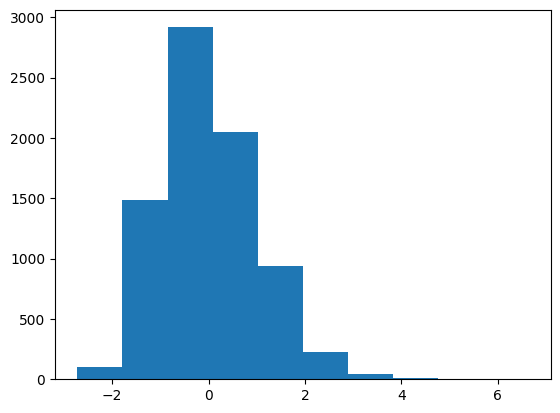

In [20]:
import matplotlib.pyplot as plt
#plt.hist(y_val)
plt.hist(y_train)

In [21]:
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import mean_squared_error

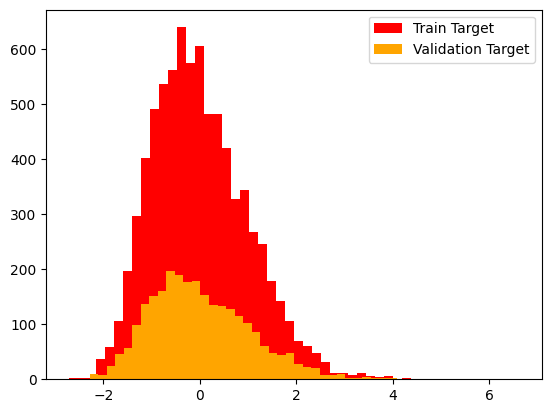

In [22]:
import matplotlib.pyplot as plt
plt.hist(y_train, color = 'red',bins=50, label = 'Train Target')
#plt.hist(y_train_resampled, color = 'blue', bins=50)
plt.hist((y_val - mu_y)/std_y, color = 'orange',bins=50, label = 'Validation Target')
plt.legend()

In [23]:
train_set = MyDataset(X_train, y_train)
val_set = MyDataset(X_val, y_val)

training_loader = DataLoader(train_set, batch_size = 1024)
validation_loader = DataLoader(val_set, batch_size = 1024)

In [24]:
def early_stopping(val_loss, patiance = 5):
  counter = 0.
  for v in range(patiance):
    if val_loss[-v] > val_loss[-v-1]:
      counter += 1.
    else:
      False

  if patiance == counter:
    return True


In [25]:
train_losses = []
val_losses = [] 

def train_regression_model(model, criterion,  val_crit, optimizer, train_loader, val_loader, num_epochs, patiance = 5):
    # set up the device to use for training
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model = 0.
    best_validation = float('inf')
    #print(mu_y, std_y)

    # train the model
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            # move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs).squeeze()
            loss = criterion(outputs*std_y + mu_y, labels.squeeze()*std_y + mu_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            #running_loss += mean_squared_error(scaler_target.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)), scaler_target.inverse_transform(labels.cpu().detach().numpy().reshape(-1, 1))).item() 

       
        epoch_loss = np.sqrt(running_loss / len(train_loader))  # calculate the average epoch loss
        running_loss = 0
        train_losses.append(epoch_loss)
        print(f"Average training loss for epoch {epoch+1}: {epoch_loss:.5f}")

        running_val_loss = 0.0

        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data

                # move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward pass
                outputs = model(inputs).squeeze() 
                loss = val_crit(outputs*std_y + mu_y, labels.squeeze())

                # accumulate validation loss
                #loss += mean_squared_error(scaler_target.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)), 
                #                              labels.cpu().detach().numpy().reshape(-1, 1)).item()
                
                running_val_loss += loss.item()
        val_loss = np.sqrt(running_val_loss / len(val_loader))
        if val_loss < best_validation:
          best_model = model
          best_validation = val_loss

        val_losses.append(val_loss.item())
        print(f"Average validation loss for epoch {epoch+1}: {val_loss:.5f}")
       
        if epoch > patiance:
          if early_stopping(val_losses,patiance):
            print('Early stopping')
            break
      
    torch.save(model.state_dict(), '/content/attempt1/epoch'+str(epoch))
    return best_model
    print('Finished Training')


In [26]:
loss_fn = torch.nn.MSELoss()
#loss_fn = my_loss
val_loss = torch.nn.MSELoss()
model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#,weight_decay = 0.000001)
train_losses = []
val_losses = [] 


In [30]:
best_model = train_regression_model(model, loss_fn, val_loss, optimizer, training_loader, validation_loader, num_epochs=100, patiance = 10)

Average training loss for epoch 1: 0.27085
Average validation loss for epoch 1: 0.30630
Average training loss for epoch 2: 0.29083
Average validation loss for epoch 2: 0.35367
Average training loss for epoch 3: 0.27868
Average validation loss for epoch 3: 0.29226
Average training loss for epoch 4: 0.25979
Average validation loss for epoch 4: 0.29167
Average training loss for epoch 5: 0.27836
Average validation loss for epoch 5: 0.31308
Average training loss for epoch 6: 0.26854
Average validation loss for epoch 6: 0.29361
Average training loss for epoch 7: 0.26771
Average validation loss for epoch 7: 0.32794
Average training loss for epoch 8: 0.27211
Average validation loss for epoch 8: 0.27990
Average training loss for epoch 9: 0.27064
Average validation loss for epoch 9: 0.28174
Average training loss for epoch 10: 0.26881
Average validation loss for epoch 10: 0.35814
Average training loss for epoch 11: 0.24562
Average validation loss for epoch 11: 0.30038
Average training loss for ep

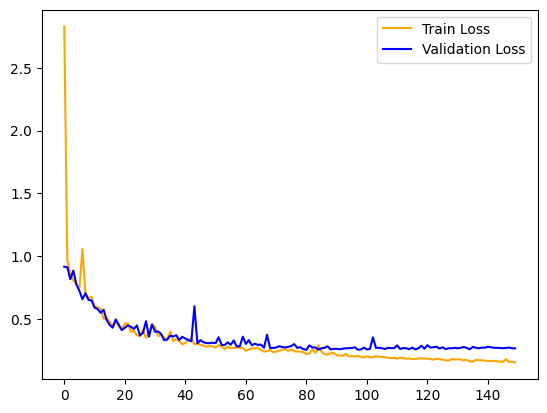

In [31]:
plt.plot(train_losses[:], color = 'orange', label = 'Train Loss')
plt.plot(val_losses[:], color = 'blue', label = 'Validation Loss')
plt.legend()

In [32]:
from sklearn.model_selection import KFold

def experiment(architecture, n_splits = 5):

    kf = KFold(n_splits=n_splits, random_state=22, shuffle=True)
    kf.get_n_splits(data)

    predict_train = np.zeros(len(data))

    for train_index, val_index in kf.split(data):

        if architecture == 'cnn':
          model = CNN()
          model.apply(init_weights)
        elif architecture == 'dnn':
          model = DNN()
          model.apply(init_weights)

        X_train = data.iloc[train_index].drop('target',axis=1)
        X_val = data.iloc[val_index].drop('target',axis=1)

        y_train = data.iloc[train_index]['target']
        y_val = data.iloc[val_index]['target']


        scaler_data = StandardScaler()
        scaler_target = StandardScaler()

        X_train = scaler_data.fit_transform(X_train)

        X_val = scaler_data.transform(X_val)

        mu_y = y_train.mean()
        std_y = y_train.std()
        y_train -= mu_y
        y_train /= std_y


        train_set = MyDataset(X_train,y_train)
        val_set = MyDataset(X_val,y_val)

        training_loader = DataLoader(train_set,batch_size = 512,)
        validation_loader = DataLoader(val_set,batch_size = 512,)
        


        val_loss = torch.nn.MSELoss()
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.05)#,weight_decay = 0.000001)


        train_losses = []
        val_losses = [] 
        best_model = train_regression_model(model, loss_fn, val_loss, optimizer, training_loader, validation_loader, num_epochs=30, patiance = 15)


        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        preds = []
        for X,y in validation_loader:
          predictions = best_model(X.to(device))
          predictions = predictions*std_y + mu_y
          for pred in predictions:
            preds.append(pred.item())

        predict_train[val_index] = np.array(preds)


    return predict_train

In [33]:
nn_preds = experiment('cnn')

Average training loss for epoch 1: 1.63762
Average validation loss for epoch 1: 1.04361
Average training loss for epoch 2: 0.80850
Average validation loss for epoch 2: 0.53061
Average training loss for epoch 3: 0.50809
Average validation loss for epoch 3: 0.43654
Average training loss for epoch 4: 0.38237
Average validation loss for epoch 4: 0.32393
Average training loss for epoch 5: 0.35431
Average validation loss for epoch 5: 0.33740
Average training loss for epoch 6: 0.31479
Average validation loss for epoch 6: 0.30255
Average training loss for epoch 7: 0.28425
Average validation loss for epoch 7: 0.25657
Average training loss for epoch 8: 0.27185
Average validation loss for epoch 8: 0.27453
Average training loss for epoch 9: 0.26545
Average validation loss for epoch 9: 0.24993
Average training loss for epoch 10: 0.30246
Average validation loss for epoch 10: 0.27624
Average training loss for epoch 11: 0.26703
Average validation loss for epoch 11: 0.26187
Average training loss for ep

In [34]:
print("MEAN RMSE FOR X: {} \nSTD OF RMSE FOR X: {}".format(*get_rmse_metric(nn_preds,data['target'].values)))

MEAN RMSE FOR X: 0.2447558256453773 
STD OF RMSE FOR X: 0.015936914275448147
